In [1]:
data_hosts_path = '/kaggle/input/olympic-data/olympic_hosts.csv'
data_medals_path = '/kaggle/input/olympic-data/olympic_medals.csv'
data_results_path = '/kaggle/input/olympic-data/olympic_results.csv'
data_athletes_path = '/kaggle/input/olympic-data/olympic_athletes.csv'

In [2]:
pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 5.0 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488493 sha256=2e174a512ab38f6ed00d5c414241bb9fa064d988284d6032c7892c087a70845f
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
Note: you may need to restart the kernel to use updated packages.


In [4]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Exploration et nettoyage des données") \
    .getOrCreate()

# Charger les données depuis le fichier CSV
df_hosts = spark.read.csv(data_hosts_path, header=True, inferSchema=True)
df_medals = spark.read.csv(data_medals_path, header=True, inferSchema=True)
df_results = spark.read.csv(data_results_path, header=True, inferSchema=True)
df_athletes = spark.read.csv(data_athletes_path, header=True, inferSchema=True)


In [5]:
# Afficher les premières observations
df_hosts.show(5)
df_hosts.printSchema()


+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|       game_slug|      game_end_date|    game_start_date|     game_location|       game_name|game_season|game_year|
+----------------+-------------------+-------------------+------------------+----------------+-----------+---------+
|    beijing-2022|2022-02-20 12:00:00|2022-02-04 15:00:00|             China|    Beijing 2022|     Winter|     2022|
|      tokyo-2020|2021-08-08 14:00:00|2021-07-23 11:00:00|             Japan|      Tokyo 2020|     Summer|     2020|
|pyeongchang-2018|2018-02-25 08:00:00|2018-02-08 23:00:00| Republic of Korea|PyeongChang 2018|     Winter|     2018|
|        rio-2016|2016-08-21 21:00:00|2016-08-05 12:00:00|            Brazil|        Rio 2016|     Summer|     2016|
|      sochi-2014|2014-02-23 16:00:00|2014-02-07 04:00:00|Russian Federation|      Sochi 2014|     Winter|     2014|
+----------------+-------------------+-------------------+------

In [6]:
df_medals.show(5)
df_medals.printSchema()

+----------------+------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+
|discipline_title|   slug_game|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|
+----------------+------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+
|         Curling|beijing-2022|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania CONSTANTINI|       Italy|          IT|                  ITA|
|         Curling|beijing-2022|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|        Amos MOSANER|       Italy|          IT|                  ITA|
|         Curling|beijing

In [7]:
df_results.show(5)
df_results.printSchema()

+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+-------------+------------+---------------------+-----------+-----------------+----------+----------+
|discipline_title|  event_title|   slug_game|participant_type|medal_type|            athletes|rank_equal|rank_position| country_name|country_code|country_3_letter_code|athlete_url|athlete_full_name|value_unit|value_type|
+----------------+-------------+------------+----------------+----------+--------------------+----------+-------------+-------------+------------+---------------------+-----------+-----------------+----------+----------+
|         Curling|Mixed Doubles|beijing-2022|        GameTeam|      GOLD|[('Stefania CONST...|     False|            1|        Italy|          IT|                  ITA|       NULL|             NULL|      NULL|      NULL|
|         Curling|Mixed Doubles|beijing-2022|        GameTeam|    SILVER|[('Kristin SKASLI...|     False|           

In [8]:
df_athletes.show(5)
df_athletes.printSchema()

+--------------------+--------------------+--------------------+----------------+------------------+--------------+----+
|         athlete_url|   athlete_full_name|games_participations|      first_game|athlete_year_birth|athlete_medals| bio|
+--------------------+--------------------+--------------------+----------------+------------------+--------------+----+
|https://olympics....|Cooper WOODS-TOPA...|                   1|    Beijing 2022|              2000|          NULL|NULL|
|https://olympics....|      Felix ELOFSSON|                   2|PyeongChang 2018|              1995|          NULL|NULL|
|https://olympics....|       Dylan WALCZYK|                   1|    Beijing 2022|              1993|          NULL|NULL|
|https://olympics....|       Olli PENTTALA|                   1|    Beijing 2022|              1995|          NULL|NULL|
|https://olympics....|    Dmitriy REIKHERD|                   1|    Beijing 2022|              1989|          NULL|NULL|
+--------------------+----------

In [9]:
from pyspark.sql.functions import col, concat_ws, lit, expr

# Effectuer la jointure des DataFrames
data = df_medals.join(df_hosts, df_medals.slug_game == df_hosts.game_slug, how='left')

# Transformer les noms des athlètes en utilisant la capitalisation des mots
data = data.withColumn("athlete_full_name", expr("initcap(athlete_full_name)"))

# Supprimer les colonnes de jointure
data = data.drop("slug_game", "game_slug")

# Supprimer les colonnes non utilisées
data = data.drop("game_end_date", "game_start_date")

# Afficher la forme du DataFrame
data_count = data.count()
data_columns = len(data.columns)

print(f"Le DataFrame final contient {data_count} lignes et {data_columns} colonnes")


Le DataFrame final contient 21697 lignes et 15 colonnes


In [10]:
data.show(5)


+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania Constantini|       Italy|          IT|                  ITA|        China|Beijing 2022|     Winter|     2022|
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|   

In [11]:
# Dictionnaires pour les remplacements
country_dict = {
    'German Democratic Republic (Germany)': 'Germany',
    'Federal Republic of Germany': 'Germany',
    "Democratic People's Republic of Korea": 'North Korea',
    "Republic of Korea": "South Korea",
    "People's Republic of China": 'China',
    "Islamic Republic of Iran": 'Iran',
    "United States of America": 'USA'
}


In [12]:
discipline_map = {
    "Gymnastics Artistic": "Artistic Gymnastics",
    "Gymnastics Rhythmic": "Rhythmic Gymnastics",
    "Synchronized Swimming": "Artistic Swimming",
    "Equestrian Dressage": "Equestrian",
    "Equestrian Jumping": "Equestrian",
    "Equestrian Eventing": "Equestrian",
    "Trampoline": "Trampoline Gymnastics",
    "Cycling BMX": "Cycling BMX Racing",
    "Short Track Speed Skating": "Short Track"
}

In [13]:
from pyspark.sql.functions import  when
# Fonction pour appliquer les remplacements
def replace_column_values(df, column, replacement_dict):
    for original, replacement in replacement_dict.items():
        df = df.withColumn(column, when(col(column) == original, replacement).otherwise(col(column)))
    return df

# Appliquer les remplacements pour les noms des pays
data = replace_column_values(data, "country_name", country_dict)

# Appliquer les remplacements pour les noms des disciplines
data = replace_column_values(data, "discipline_title", discipline_map)

# Afficher les 5 premières lignes du DataFrame final
data.show(5)

+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania Constantini|       Italy|          IT|                  ITA|        China|Beijing 2022|     Winter|     2022|
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|   

The dataset contains two different rows for both winners in a team competition that consists of two persons, but it is one medal in total. For example, you can check the Tennis Doubles Men competition. Let's split the dataset into parts, group those team competitions, and join data again.

In [14]:
# Filtrer les données pour les athlètes
data_athlete = data.filter(col('participant_type') == 'Athlete')

# Obtenir le nombre de lignes et de colonnes
num_rows = data_athlete.count()
num_cols = len(data_athlete.columns)

print(f"Le DataFrame des athlètes contient {num_rows} lignes et {num_cols} colonnes")
# Afficher les 5 premières lignes du DataFrame des athlètes
data_athlete.show(5)


Le DataFrame des athlètes contient 15113 lignes et 15 colonnes
+----------------+--------------------+------------+----------+----------------+-----------------+--------------------+-----------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|         event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+--------------------+------------+----------+----------------+-----------------+--------------------+-----------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|Freestyle Skiing|        Men's Moguls|         Men|    SILVER|         Athlete|             NULL|https://olympics....| Mikael Kingsbury|      Canada|          CA|                  CAN|        China|Beijing 2022|     Winter|     202

In [15]:
# Filtrer les données pour les équipes
data_team = data.filter(col('participant_type') == 'GameTeam')

# Obtenir le nombre de lignes et de colonnes
num_rows = data_team.count()
num_cols = len(data_team.columns)

print(f"Le DataFrame des équipes contient {num_rows} lignes et {num_cols} colonnes")

# Afficher les 5 premières lignes du DataFrame des équipes
data_team.show(5)


Le DataFrame des équipes contient 6584 lignes et 15 colonnes
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|  event_title|event_gender|medal_type|participant_type|participant_title|         athlete_url|   athlete_full_name|country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------+------------+----------+----------------+-----------------+--------------------+--------------------+------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|Mixed Doubles|       Mixed|      GOLD|        GameTeam|            Italy|https://olympics....|Stefania Constantini|       Italy|          IT|                  ITA|        China|Beijing 2022|     Winter|     2022|
|         Curli

In [16]:
# Filtrer les données où `athlete_full_name` est null
data_team_a = data_team.filter(col('athlete_full_name').isNull())

# Obtenir le nombre de lignes et de colonnes
num_rows_team_a = data_team_a.count()
num_cols_team_a = len(data_team_a.columns)

print(f"Le DataFrame des équipes avec `athlete_full_name` null contient {num_rows_team_a} lignes et {num_cols_team_a} colonnes")

# Afficher les 5 premières lignes du DataFrame filtré
data_team_a.show(5)


Le DataFrame des équipes avec `athlete_full_name` null contient 3624 lignes et 15 colonnes
+----------------+-----------+------------+----------+----------------+-----------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|event_title|event_gender|medal_type|participant_type|participant_title|athlete_url|athlete_full_name| country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-----------+------------+----------+----------------+-----------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|      Women|       Women|      GOLD|        GameTeam|    Great Britain|       NULL|             NULL|Great Britain|          GB|                  GBR|        China|Beijing 2022|     Winter|     2022|
|         Curling|      Women|       

In [17]:
from pyspark.sql.functions import col, expr, when, isnull, collect_set, first, udf
from pyspark.sql.types import ArrayType, StringType

data_team_b = data_team.filter(col('athlete_full_name').isNotNull())

# Colonnes pour le groupement
group_columns = ['discipline_title', 'event_title', 'event_gender', 'medal_type', 'participant_type', 'participant_title',
                 'country_name', 'country_3_letter_code', 'game_location', 'game_season', 'game_name', 'game_year']

# Colonnes pour l'agrégation
agg_columns = ['country_code', 'athlete_full_name']

# Grouper par les colonnes spécifiées et agréger
data_team_b_grouped = data_team_b.groupBy(group_columns).agg(
    first('country_code').alias('country_code'),
    collect_set('athlete_full_name').alias('athlete_full_names')
)

# Convertir `collect_set` de `athlete_full_name` en liste
@udf(ArrayType(StringType()))
def to_list(x):
    return list(x)

data_team_b_grouped = data_team_b_grouped.withColumn('athlete_full_names', to_list(col('athlete_full_names')))

# Afficher le nombre de lignes et de colonnes
num_rows_team_b = data_team_b_grouped.count()
num_cols_team_b = len(data_team_b_grouped.columns)

print(f"Le DataFrame des équipes agrégé contient {num_rows_team_b} lignes et {num_cols_team_b} colonnes")

# Afficher les 5 premières lignes du DataFrame agrégé
data_team_b_grouped.show(5)


Le DataFrame des équipes agrégé contient 1480 lignes et 14 colonnes


+-------------------+--------------------+------------+----------+----------------+--------------------+------------+---------------------+-------------+-----------+-----------+---------+------------+--------------------+
|   discipline_title|         event_title|event_gender|medal_type|participant_type|   participant_title|country_name|country_3_letter_code|game_location|game_season|  game_name|game_year|country_code|  athlete_full_names|
+-------------------+--------------------+------------+----------+----------------+--------------------+------------+---------------------+-------------+-----------+-----------+---------+------------+--------------------+
|            Archery|          Mixed Team|       Mixed|    BRONZE|        GameTeam|              Mexico|      Mexico|                  MEX|        Japan|     Summer| Tokyo 2020|     2020|          MX|[Luis Alvarez, Al...|
|            Archery|          Mixed Team|       Mixed|      GOLD|        GameTeam|   Republic of Korea| South K

In [18]:
# Concaténer les DataFrames
data_medal = data_team_a.union(data_team_b).union(data_athlete)
# Obtenir le nombre total de lignes
total_rows = data_medal.count()
print("Le DataFrame concaténé contient {} lignes".format(total_rows))


Le DataFrame concaténé contient 21697 lignes


In [19]:
from pyspark.sql.functions import when

data_medal = data_medal.withColumn("discipline_title", 
                                   when(data_medal["event_title"] == "Baseball", "Baseball")
                                   .when(data_medal["event_title"] == "Softball", "Softball")
                                   .otherwise(data_medal["discipline_title"]))

data_medal = data_medal.withColumn("event_title", 
                                   when(data_medal["event_title"] == "Baseball", "baseball men")
                                   .when(data_medal["event_title"] == "Softball", "softball women")
                                   .otherwise(data_medal["event_title"]))
data_medal = data_medal.withColumn("discipline_title", 
                                   when(data_medal["event_title"] == "rugby-7 men", "Rugby Sevens")
                                   .when(data_medal["event_title"] == "rugby-7 women", "Rugby Sevens")
                                   .otherwise(data_medal["discipline_title"]))

data_medal = data_medal.withColumn("event_title", 
                                   when(data_medal["event_title"] == "rugby-7 men", "Men")
                                   .when(data_medal["event_title"] == "rugby-7 women", "Women")
                                   .otherwise(data_medal["event_title"]))


In [21]:
from pyspark.sql.functions import count, when
from pyspark.sql import DataFrame

def get_disciplines_game(df: DataFrame, season: str):
    # Filtrer les données pour la saison spécifiée
    df_season = df.filter(df['game_season'] == season)

    # Compter le nombre de participants par discipline et année
    df_disciplines_year = df_season.groupby('discipline_title', 'game_year') \
        .agg(count('participant_type').alias('participant_count'))

    # Pivoter les données pour avoir les années comme colonnes et les disciplines comme lignes
    df_heatmap = df_disciplines_year.groupby('discipline_title') \
        .pivot('game_year') \
        .agg(when(count('participant_count') > 0, 1).otherwise(0)) \
        .fillna(0)

    # Renommer les colonnes
    df_heatmap = df_heatmap.toPandas()
    df_heatmap.columns = [str(col) for col in df_heatmap.columns]

    # Remplacer les espaces dans l'index par des sauts de ligne
    df_heatmap.index = [str(idx).replace(' ', '\n', 1) for idx in df_heatmap.index]

    return df_heatmap



In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disciplines(data, title, size=(16, 16)):
    '''
    Return plot
    '''
    plt.figure(figsize=size)
    ax = sns.heatmap(data.to_pandas(), annot=False, cbar=False, 
                     linewidths=0.8, linecolor='black', 
                     square=True, cmap='Spectral')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    ax.spines[['bottom', 'right']].set_visible(True)
    ax.set_title('{} Games'.format(title), size=22)
    plt.tight_layout()
    plt.show()


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_disciplines(data, title, size=(16, 16)):
    '''
    Return plot
    '''
    # Créer un mapping des disciplines sportives à des valeurs numériques
    discipline_mapping = {discipline: i for i, discipline in enumerate(data.index)}
    
    # Convertir les noms des disciplines sportives en valeurs numériques
    data_numeric = data.rename(index=discipline_mapping)
    
    plt.figure(figsize=size)
    ax = sns.heatmap(data_numeric, annot=False, cbar=False, 
                     linewidths=0.8, linecolor='black', 
                     square=True, cmap='Spectral')
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=16)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.xaxis.tick_top()
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none') 
    ax.spines[['bottom', 'right']].set_visible(True)
    ax.set_title('{} Games'.format(title), size=22)
    plt.tight_layout()
    plt.show()


# Obtention des données pour la saison spécifiée
season = 'Summer'
size = (20, 38)

# Obtention des données pour la saison spécifiée
disciplines = get_disciplines_game(data_medal, season)

# Traçage des disciplines
plot_disciplines(disciplines, title=season, size=size)



24/05/29 07:54:02 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


ValueError: could not convert string to float: 'Tennis'

<Figure size 2000x3800 with 0 Axes>

In [24]:
from pyspark.sql.functions import col

# Filtrer les données pour ne conserver que les jeux d'été et supprimer la colonne 'game_season'
data_summer = data_medal.filter(col('game_season') == 'Summer').drop('game_season')



In [25]:
data_summer.show()

+-----------------+--------------------+------------+----------+----------------+-----------------+-----------+-----------------+------------+------------+---------------------+-------------+----------+---------+
| discipline_title|         event_title|event_gender|medal_type|participant_type|participant_title|athlete_url|athlete_full_name|country_name|country_code|country_3_letter_code|game_location| game_name|game_year|
+-----------------+--------------------+------------+----------+----------------+-----------------+-----------+-----------------+------------+------------+---------------------+-------------+----------+---------+
|     Canoe Sprint|Men's Kayak Four ...|         Men|      GOLD|        GameTeam|          Germany|       NULL|             NULL|     Germany|          DE|                  GER|        Japan|Tokyo 2020|     2020|
|     Canoe Sprint|Men's Kayak Four ...|         Men|    SILVER|        GameTeam|            Spain|       NULL|             NULL|       Spain|      

In [36]:
data_medal.show()

# Assuming 'data_medal' is your PySpark DataFrame
data_medal.write.csv('/kaggle/working/data_medal', header=True)


+----------------+-------------------+------------+----------+----------------+--------------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|discipline_title|        event_title|event_gender|medal_type|participant_type|   participant_title|athlete_url|athlete_full_name| country_name|country_code|country_3_letter_code|game_location|   game_name|game_season|game_year|
+----------------+-------------------+------------+----------+----------------+--------------------+-----------+-----------------+-------------+------------+---------------------+-------------+------------+-----------+---------+
|         Curling|              Women|       Women|      GOLD|        GameTeam|       Great Britain|       NULL|             NULL|Great Britain|          GB|                  GBR|        China|Beijing 2022|     Winter|     2022|
|         Curling|              Women|       Women|    SILVER|        GameTeam|     

In [27]:
def sort_games_name(game_name_list):
    '''
    Input: ['Sydney 2000', 'Atlanta 1996', 'Beijing 2008', 'Athens 2004']
    Output: ['Atlanta 1996', 'Sydney 2000', 'Athens 2004', 'Beijing 2008'
    '''
    game_name_tuple_split = [(i[:-5], i[-4:]) for i in game_name_list]
    game_name_tuple_sorted = sorted(game_name_tuple_split, key=lambda x: x[1])
    game_name_list_sorted = [' '.join(i) for i in game_name_tuple_sorted]
    return game_name_list_sorted

from pyspark.sql.functions import col

def get_country_medal(data, country):
    data_country = data.filter(data['country_name'] == country)
    data_medal = data_country.groupby(['game_name', 'discipline_title']) \
                             .agg({'participant_type': 'count'}) \
                             .withColumnRenamed('count(participant_type)', 'participant_type') \
                             .toPandas()
    data_medal = data_medal.pivot_table(index='discipline_title', columns='game_name', values='participant_type', fill_value=0)
    sorted_columns = sort_games_name(data_medal.columns)
    data_medal = data_medal.reindex(columns=sorted_columns)
    data_medal['Total'] = data_medal.sum(axis=1)
    data_medal.loc["Total"] = data_medal.sum()
    return data_medal




def plot_country_medal(data, figsize=(20, 20)):
    plt.figure(figsize=figsize)
    ax = sns.heatmap(data, annot=True, annot_kws={"fontsize":20},
                     cbar=False, linewidths=.8, fmt='g', cmap='coolwarm')
#     ax.set_title('Team', size=20)
    ax.tick_params(axis='x', which='major', labelsize=5)
    ax.tick_params(axis='y', which='major', labelsize=16)
    ax.xaxis.tick_top()
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.tight_layout()
#     plt.savefig('medals.png', dpi=300)
    plt.show()


In [28]:
from pyspark.sql.functions import count

country_medal = data_summer.groupby('country_name') \
                           .agg(count('participant_type').alias('total_number')) \
                           .sort('total_number', ascending=False) \
                           .limit(10)


In [29]:
country_medal.show()


+-------------+------------+
| country_name|total_number|
+-------------+------------+
|          USA|        2732|
|      Germany|        1491|
| Soviet Union|        1055|
|Great Britain|        1008|
|       France|         805|
|        China|         723|
|        Italy|         646|
|    Australia|         608|
|      Hungary|         543|
|       Sweden|         525|
+-------------+------------+



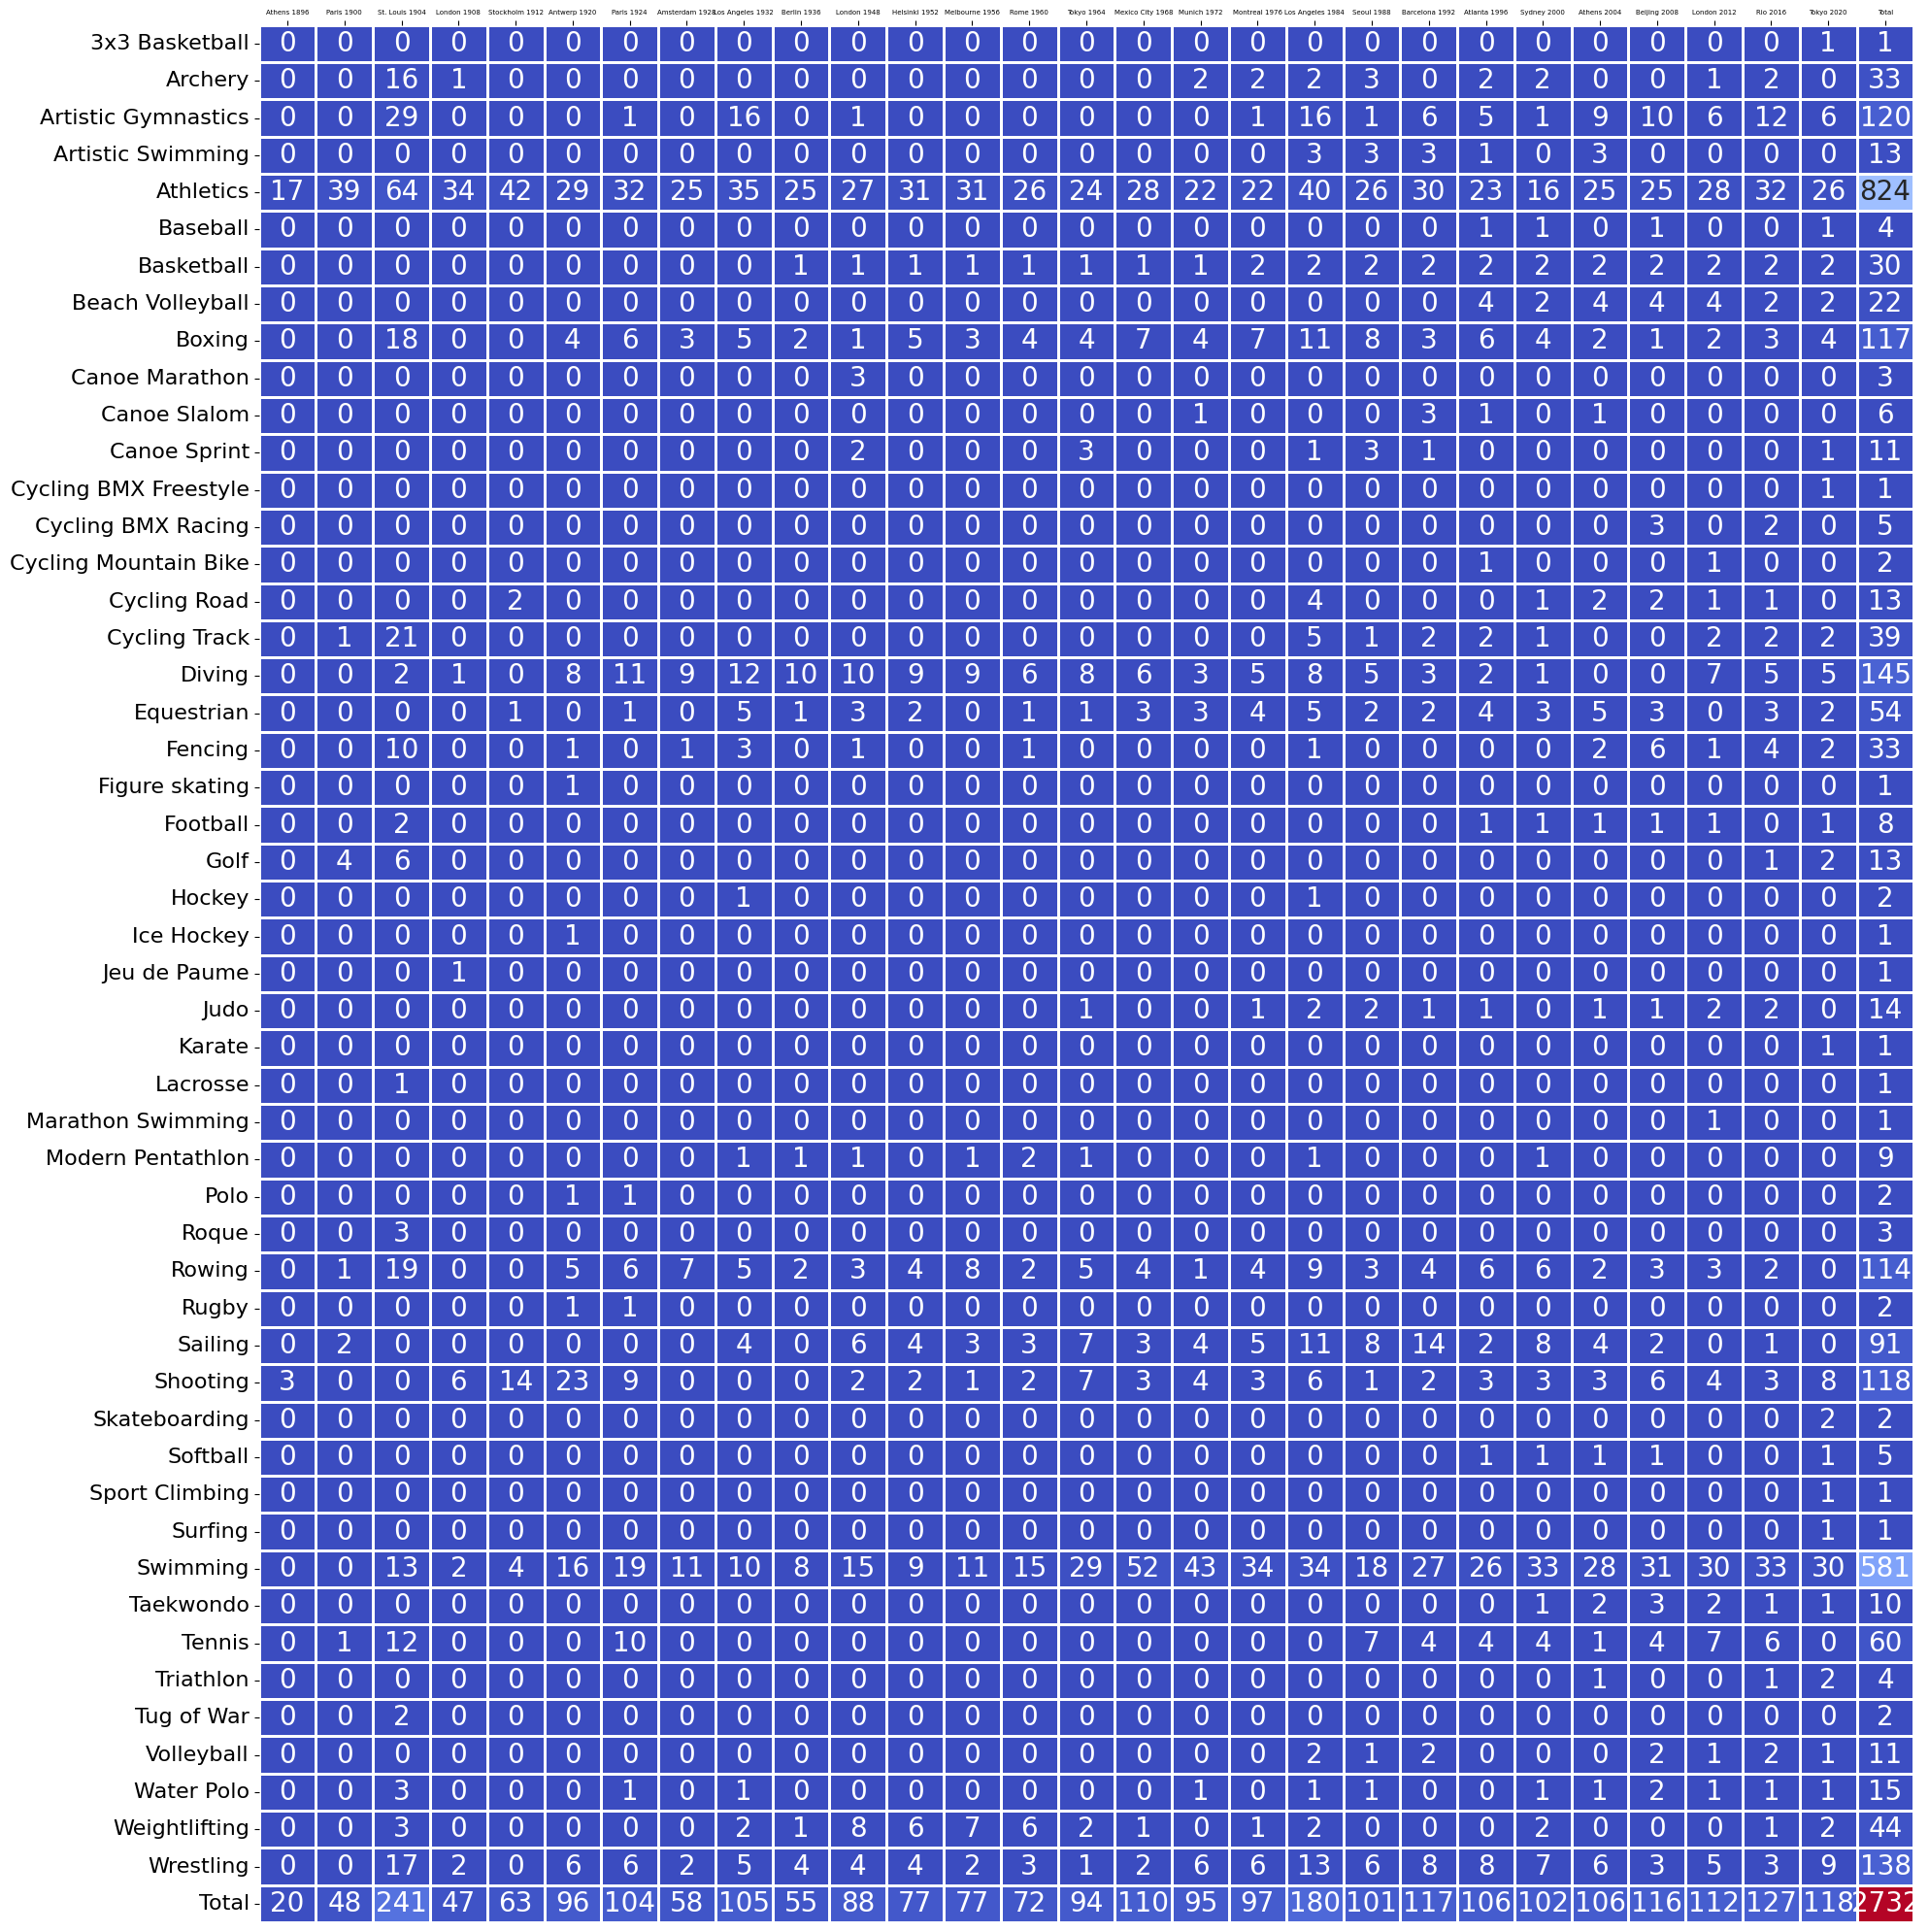

In [30]:
country_medal_usa = get_country_medal(data_summer, 'USA')
plot_country_medal(country_medal_usa)

In [1]:
country_medal_usa = get_country_medal(data_summer, 'Germany')
plot_country_medal(country_medal_usa)

NameError: name 'get_country_medal' is not defined

In [37]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("Olympics Medal Prediction") \
    .config("spark.executor.memory", "4g") \
    .config("spark.driver.memory", "4g") \
    .config("spark.memory.fraction", "0.8") \
    .config("spark.sql.execution.arrow.enabled", "true") \
    .getOrCreate()


24/05/29 08:41:13 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 08:41:13 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


In [38]:
from pyspark.sql.functions import col, when
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

# Charger les données
data_medal = spark.read.csv('/kaggle/working/data_medal', header=True, inferSchema=True)

# Remplacer les valeurs nulles par une valeur spécifique ou supprimer les lignes avec des nulls
data_medal = data_medal.na.fill('Unknown')

# Définir les colonnes catégorielles
categorical_columns = ['discipline_title', 'event_title', 'event_gender', 'medal_type', 
                       'participant_type', 'participant_title', 'country_name', 
                       'country_code', 'country_3_letter_code', 'game_location', 
                       'game_name', 'game_season']

# Encodage des colonnes catégorielles et gestion des valeurs NULL
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index", handleInvalid="skip") for column in categorical_columns]

# Assembler les fonctionnalités en un seul vecteur
assembler = VectorAssembler(
    inputCols=[column+"_index" for column in categorical_columns if column != 'medal_type'],
    outputCol="features"
)

# Normalisation des fonctionnalités
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures")

# Créer le pipeline de transformations
pipeline = Pipeline(stages=indexers + [assembler, scaler])

# Ajuster et transformer les données
data_preprocessed = pipeline.fit(data_medal).transform(data_medal)

# Sélectionner les fonctionnalités et l'étiquette
data_preprocessed = data_preprocessed.withColumn("label", col("medal_type_index")).select("scaledFeatures", "label")


24/05/29 08:41:57 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 08:41:57 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.
24/05/29 08:41:57 WARN SQLConf: The SQL config 'spark.sql.execution.arrow.enabled' has been deprecated in Spark v3.0 and may be removed in the future. Use 'spark.sql.execution.arrow.pyspark.enabled' instead of it.


In [39]:
data_pandas = data_preprocessed.select("scaledFeatures", "label").toPandas()

X = np.array(data_pandas['scaledFeatures'].tolist())
y = data_pandas['label'].values


In [40]:
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Séparation des données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Définir le modèle
model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, input_dim=X_train.shape[1], activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(np.unique(y)), activation='softmax')  # Pour la classification
])

# Compiler le modèle
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Entraîner le modèle
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))

# Évaluer le modèle
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy}')


Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.3472 - loss: 1.1129 - val_accuracy: 0.3694 - val_loss: 1.0949
Epoch 2/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3628 - loss: 1.0963 - val_accuracy: 0.3671 - val_loss: 1.0942
Epoch 3/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3555 - loss: 1.0970 - val_accuracy: 0.3700 - val_loss: 1.0936
Epoch 4/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3574 - loss: 1.0960 - val_accuracy: 0.3707 - val_loss: 1.0940
Epoch 5/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3707 - loss: 1.0935 - val_accuracy: 0.3654 - val_loss: 1.0925
Epoch 6/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3664 - loss: 1.0937 - val_accuracy: 0.3680 - val_loss: 1.0937
Epoch 7/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3703 - loss: 1.0935 - val_accuracy: 0.3664 - val_loss: 1.0926
Epoch 8/100
543/543 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3716 - loss: 1.0931 - val_accuracy: 0.3700